## Neural Machine Translation

## Introduction
In this notebook, we will build a deep neural network that functions as part of an end-to-end machine translation pipeline. The completed pipeline will accept french text as input and return the english translation.

__Proposed Approach__

- Preprocessing: Load and examine data, cleaning, tokenization, padding
- Modeling: Build an encoder-decoder model with Attention
- Prediction: Generate specific translations of French to English, and compare the output translations to the ground truth translations

In [1]:
!pip install keras

In [2]:
from __future__ import print_function, division
from builtins import range, input
import pickle
import os, sys
import string
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
#from keras.optimizers import adam
from keras import optimizers
from sklearn.model_selection import train_test_split



### Model Configurations

In [3]:
# config
BATCH_SIZE = 512
EPOCHS = 10
LATENT_DIM = 256
LATENT_DIM_DECODER = 256
EMBEDDING_DIM = 200


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  

### Load Data - Train and Test
The `data_en` file contains English sentences with their French translations in the `data_fr` file. Load the English and French data from these files from running the cell below.

In [5]:
import pandas as pd

# Replace 'path_to_your_dataset.csv' with the actual path to your dataset file
dataset_path = '/content/drive/MyDrive/NLP/translation/sentences.csv'

# Read the dataset into a pandas DataFrame
# You may need to adjust parameters like 'sep' depending on the format of your file
df = pd.read_csv(dataset_path, sep=',')
df.columns = ['english', 'darija']

# Example: Printing the first few entries
print(df.head())

# Now, extract the English and Darija sentences into lists
english_sentences = df['english'].tolist()
darija_sentences = df['darija'].tolist()

                                             english  \
0                They're hiding something, I'm sure!   
1    It's obvious they're trying to keep their cool.   
2            the hotels don't seem very comfortable.   
3  he is probably about to be laid off by head of...   
4                         of course he's depressive!   

                                   darija  
0    homa mkhbbyin chi haja, ana mti99en!  
1      bayna homa tay7awlo ib9aw mbrrdin.  
2  loTilat mabaynach fihom mori7in bzzaf.  
3      ghaliban ghayjrriw 3lih mn lkhdma!  
4                     Tab3an rah mkta2eb!  


In [6]:
input_texts = [] # Darija sentences
target_texts = [] # English sentences
target_texts_inputs = [] # English sentences offset by 1 for teacher forcing

# Converting to lowercase
darija_train=[line.lower() for line in darija_sentences] # Replace fr_train with darija_sentences
en_train=[line.lower() for line in english_sentences] # Replace en_train with english_sentences

NUM_SAMPLES=len(darija_train) # Replace fr_train with darija_train
print("Sample train size:",NUM_SAMPLES)

Sample train size: 10001


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
darija_train, darija_test, english_train, english_test = train_test_split(darija_train,en_train, test_size=0.6)

print("Train set size (Darija):", len(darija_train))
print("Train set size (English):", len(english_train))
print("Test set size (Darija):", len(darija_test))
print("Test set size (English):", len(english_test))

Train set size (Darija): 4000
Train set size (English): 4000
Test set size (Darija): 6001
Test set size (English): 6001


From looking at the sentences, you can see that they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.

## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Add start and end tokens to the sentences
2. Tokenize the words of the sentences
3. Add padding to make all the sequences of same length.

Time to start preprocessing the data...
### Tokenize
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.


### Padding
When batching the sequence of word ids together, each sequence needs to be the same length. Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the end of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

__Preprocess Train Data__

In [8]:
#Adding <sos> and <eos> tokens



for lines in english_train:
    target_texts_inputs.append('<sos>'+" "+ lines)

for lines in english_train:
    target_texts.append(lines+ " " +'<eos>')

for lines in darija_train:
    input_texts.append(lines)

In [9]:
# tokenize Darija sentences
tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# word to index mapping for Darija
word2idx_inputs = tokenizer_inputs.word_index

# Max length of Darija sentence
max_len_input = max(len(s) for s in input_sequences)

# tokenize English sentences
tokenizer_outputs = Tokenizer(filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# Word to index mapping for English
word2idx_outputs = tokenizer_outputs.word_index

# store number of output words for later
num_words_output = len(word2idx_outputs) + 1

# Max length of English sentence
max_len_target = max(len(s) for s in target_sequences)

# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

print('Data Preprocessed')
print("Max train English sentence length:", max_len_target)
print("Max train Darija sentence length:", max_len_input)  # Change reference from French to Darija
print("Unique Darija Vocabulary count:",len(word2idx_inputs))  # Change reference from French to Darija
print("Unique English Vocabulary count:",len(word2idx_outputs))

Data Preprocessed
Max train English sentence length: 32
Max train Darija sentence length: 24
Unique Darija Vocabulary count: 6385
Unique English Vocabulary count: 4056


__Preprocess Test Data__

In [10]:
##Test Preparation
input_texts_test = [] # Darija sentences
target_texts_test = [] # English sentences
target_texts_inputs_test = [] # English sentences offset by 1 for teacher forcing

#Converting to lowercase
darija_test = [line.lower() for line in darija_test] # Changed from fr_test to darija_test
english_test = [line.lower() for line in english_test] # Changed from en_test to english_test

In [11]:
#Adding <sos> and <eos> tokens

for lines in english_test:
    target_texts_inputs_test.append('<sos>'+" "+ lines)

for lines in english_test:
    target_texts_test.append(lines+ " " +'<eos>')

for lines in darija_test:
    input_texts_test.append(lines)

In [12]:
# tokenize Darija sentences

input_sequences_test = tokenizer_inputs.texts_to_sequences(input_texts_test)


target_sequences_test = tokenizer_outputs.texts_to_sequences(target_texts_test)
target_sequences_inputs_test = tokenizer_outputs.texts_to_sequences(target_texts_inputs_test)

# pad the sequences
encoder_inputs_test = pad_sequences(input_sequences_test, maxlen=max_len_input)
decoder_inputs_test = pad_sequences(target_sequences_inputs_test, maxlen=max_len_target, padding='post')
decoder_targets_test = pad_sequences(target_sequences_test, maxlen=max_len_target, padding='post')

print("Max test English sentence length:", decoder_inputs_test.shape[1])
print("Max test Darija sentence length:", encoder_inputs_test.shape[1])  # Changed reference from French to Darija

Max test English sentence length: 32
Max test Darija sentence length: 24


### Embedding

In word embeddings, every word is represented as an n-dimensional dense vector. The words that are similar will have similar vector. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.

For French sentences, i.e. the inputs, we will use the [`GloVe`](https://nlp.stanford.edu/projects/glove/) word embeddings. For the translated English sentences in the output, we will use custom word embeddings.

Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values, as shown below:

In [13]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

path = '/content/drive/MyDrive/NLP/translation/syntactic categories'
files = os.listdir(path)

df = pd.DataFrame()

# read all .csv files and assign category based on file name
for file in files:
    if file.endswith('.csv'):
        category = file[:-4]  # remove '.csv'
        df_temp = pd.read_csv(os.path.join(path, file), names=['word'])
        df_temp['category'] = category
        df = pd.concat([df, df_temp])

# create one-hot encoding of the categories
encoder = OneHotEncoder()
encoded_categories = encoder.fit_transform(df[['category']]).toarray()

# create dictionary mapping words to one-hot encoded categories
word2vec = dict(zip(df['word'], encoded_categories))

print('Found %s word vectors.' % len(word2vec))

Found 6203 word vectors.


In [14]:
import random

# Get unique categories
categories = df['category'].unique()

# Empty dict to store a random word from each category
random_words = {}

# Get a random word from each category
for category in categories:
    words_in_category = df[df['category'] == category]['word']
    random_word = random.choice(words_in_category)
    random_words[random_word] = {"vector": word2vec[random_word], "category": category}

# Print the random words and their vectors
for word, info in random_words.items():
    print("Word:", word)
    print("Category:", info["category"])
    print("Vector:", info["vector"])
    print()

Word: 7tejjo
Category: imperatives
Vector: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

Word: when
Category: pronouns
Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

Word: building
Category: nouns
Vector: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

Word: ma7llyat
Category: masculine_feminine_plural
Vector: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

Word: kayrklo
Category: conjug_present
Vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

Word: ttomobil
Category: (in)definite
Vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Word: already
Category: adverbs
Vector: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Word: inside
Category: prepositions
Vector: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

Word: slow
Category: adjectives
Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Word: 9Ti3
Category: verb-to-noun
Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

Word: excuse
Category: verbs
Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Word: rfDo
Category: conjug_past
Vector: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]



In [15]:
print("Categories:", encoder.categories_)

Categories: [array(['(in)definite', 'adjectives', 'adverbs', 'conjug_past',
       'conjug_present', 'imperatives', 'masculine_feminine_plural',
       'nouns', 'prepositions', 'pronouns', 'verb-to-noun', 'verbs'],
      dtype=object)]


In [16]:
import numpy as np

# vocabulary size (add 1 because index 0 is reserved for padding)
vocabulary_size = len(tokenizer_inputs.word_index) + 1

# dimensionality of GloVe word vectors
embedding_dim = len(next(iter(word2vec.values())))

# prepare embedding matrix
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer_inputs.word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [17]:
from keras.layers import Embedding

embedding_layer = Embedding(input_dim=vocabulary_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)

### Creating the Model
The idea is to have two recurrent neural networks (RNNs) with an encoder-decoder architecture: read the input words one by one to obtain a vector representation of a fixed dimensionality (encoder), and, conditioned on these inputs, extract the output words one by one using another RNN (decoder).


### Define Softmax Activation Function

In [18]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

### Define Embedding Layer

In [19]:
from keras.layers import Embedding

embedding_layer = Embedding(input_dim=vocabulary_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)

### One-hot Encoding

To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word.

In [20]:

decoder_targets_one_hot = np.zeros(
  (
    len(darija_train),  # changed from input_texts to darija_train
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

### Define Encoding Layer
The input to the encoder will be the sentence in French and the output will be the hidden state and cell state of the LSTM.

In [21]:
#encoder
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True, dropout=0.2
))
encoder_outputs = encoder(x)


### Define Decoder Layer

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an "</sos/>" token appended at the beginning.

In [22]:
#Decoder
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)



### Define Attention Layers

To improve the performance of the Neural Machine Translator, Attention mechanism (Dot attention) is implemented. The attention model develops a context vector that is filtered specifically for each output time step.

Attention places different focus on different words by assigning each word with a score. Then, using the softmaxed scores, we aggregate the encoder hidden states using a weighted sum of the encoder hidden states, to get the context vector.

Rather than re-iterating through the equations for calculating attention, a function `one_step_attention` is defined.

In [23]:
#Attention
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)

attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]


In [24]:
def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)

  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context


In [25]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [26]:
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)

  # combine
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

In [27]:
def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

# make it a layerx``
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)


In [28]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s,
    initial_c,
  ],
  outputs=outputs
)

### Model Training

In [29]:
learning_rate=0.001
# checkpoint
filepath="darija_eng_finalmodel"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# compile the model

model.compile(optimizer=optimizers.Adam(learning_rate) ,loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
# train the model
z = np.zeros((encoder_inputs.shape[0], LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
    callbacks=callbacks_list
)


Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 7.9916 - accuracy: 0.6558 
Epoch 1: val_accuracy improved from -inf to 0.78625, saving model to darija_eng_finalmodel
7/7 [==============================] - 239s 22s/step - loss: 7.9916 - accuracy: 0.6558 - val_loss: 5.9422 - val_accuracy: 0.7862
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 4.1300 - accuracy: 0.7802 
Epoch 2: val_accuracy did not improve from 0.78625
7/7 [==============================] - 91s 13s/step - loss: 4.1300 - accuracy: 0.7802 - val_loss: 2.0125 - val_accuracy: 0.7862
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 1.8873 - accuracy: 0.7802 
Epoch 3: val_accuracy did not improve from 0.78625
7/7 [==============================] - 90s 13s/step - loss: 1.8873 - accuracy: 0.7802 - val_loss: 1.7878 - val_accuracy: 0.7862
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 1.8351 - accuracy: 0.7802 
Epoch 4: val_accuracy did not improve from 0.78625

In [36]:
model.save("darija_to_english__model.h5")

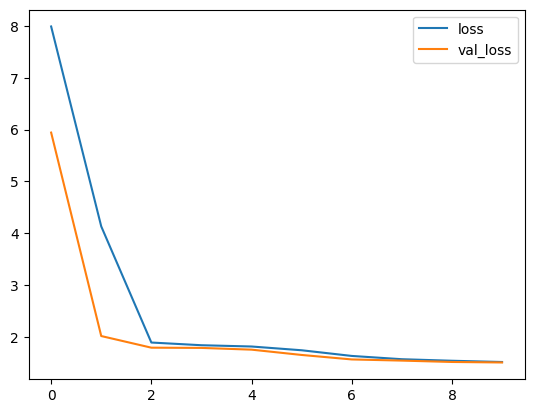

In [31]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()



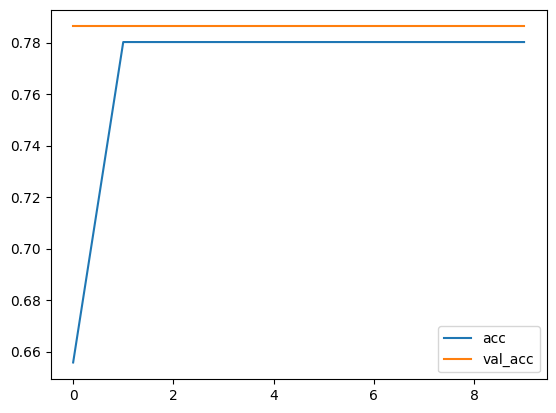

In [32]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


### Modifying the model for Predictions
While training, we know the actual inputs to the decoder for all the output words in the sequence. However, during predictions the next word will be predicted on the basis of the previous word, which in turn is also predicted in the previous time-step.

While making actual predictions, the full output sequence is not available, in fact that is what we have to predict. During prediction the only start and end token is avaialbale to us. We will use this to predict the output sentences.

In [33]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [34]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s,
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)


In [35]:
decoder_model.save("darija_to_english_decoder_model.h5")
encoder_model.save("darija_to_english_encoder_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Making Predictions

In the tokenization steps, we converted words to integers. The outputs from the decoder will also be integers. However, we want our output to be a sequence of words in the French language. To do so, we need to convert the integers back to words. We will create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words.

In [ ]:
idx2word_darija = {v:k for k, v in word2idx_inputs.items()}
idx2word_english = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
import pickle
pickle.dump(idx2word_darija, open("idx2word_darija.pkl", "wb" ))
pickle.dump(idx2word_english, open("idx2word_english.pkl", "wb" ))
pickle.dump(tokenizer_inputs, open("tokenizer_darija.pkl", "wb" ))

The decode_sequence() method will accept an input-padded sequence french sentence (in the integer form) and will return the translated english sentence.

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_english[idx]  # changed from idx2word_trans to idx2word_english
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

### Testing the model
To test the model, we use the french sentences from the test set, retrieve the corresponding padded sequence for the sentence, and will pass it to the decode_sequence() method. The method will return the translated sentence as shown below.

In [ ]:
test_actual_sentence = []
test_predicted_sentence = []
for i in range(len(darija_test)):  # replace fr_test with your actual Darija test data variable
    input_seq = encoder_inputs_test[i:i+1]  # assuming that encoder_inputs_test contains the preprocessed Darija test data (i.e., tokenized, padded, etc)
    translation = decode_sequence(input_seq)
    test_actual_sentence.append(english_test[i])  # assuming english_test contains the corresponding English translations
    test_predicted_sentence.append(translation)

In [ ]:
for i in np.random.randint(0, len(darija_test), 5):  # Adjust the range to the size of your test data
    print('-')
    print('Input sentence:', darija_test[i])  # Darija test sentence
    print('Predicted translation:', test_predicted_sentence[i])  # Predicted English translation
    print('Actual translation:', english_test[i])  # Actual English translation

-
Input sentence: soyez polis avec vos parents
Predicted translation: be polite to your parents
Actual translation: be polite to your parents <eos>
-
Input sentence: ma vie pour une bière
Predicted translation: my life is like to beer
Actual translation: im dying for a beer <eos>
-
Input sentence: je suis heureuse que vous veniez
Predicted translation: im glad youre coming
Actual translation: im glad youre coming <eos>
-
Input sentence: sa voiture a deux ans
Predicted translation: his car is two years old
Actual translation: his car is two years old <eos>
-
Input sentence: désolée je ne vous ai pas entendus
Predicted translation: sorry i didnt hear you
Actual translation: sorry i didnt hear you <eos>


### Evaluation metric: BLEU Score

BLEU, or the Bilingual Evaluation Understudy, is a score for comparing a candidate translation of text to one or more reference translations. NLTK also provides a function called corpus_bleu() for calculating the BLEU score for multiple sentences such as a paragraph or a document.

The references must be specified as a list of sentences where each sentence is a list of references and each alternative reference is a list of tokens, e.g. a list of lists of lists of tokens. The candidate sentences must be specified as a list where each sentence is a list of tokens

Here we will be passing predicted translations as list of candidate sentences and actual sentences as list of reference sentences.


In [ ]:
import nltk
pred=[]
for words in test_predicted_sentence:
    pred.append(words.split())

In [ ]:
actual=[]
for words in test_actual_sentence:
    actual.append(words.split())

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()
BLEUscore = nltk.translate.bleu_score.corpus_bleu(actual,pred,smoothing_function=chencherry.method4)
print(BLEUscore)

0.2860901377075264


In [ ]:
import sacrebleu
x=sacrebleu.raw_corpus_bleu(test_predicted_sentence,[test_actual_sentence])
print(x)

BLEU = 37.88 68.3/51.5/41.6/35.5 (BP = 0.794 ratio = 0.812 hyp_len = 59438 ref_len = 73164)
